# How to Create a Composite SED
This notebook is intended to be used as a demonstration on how to create a composite SED from a SED or set of SED galaxies, and an AGN model. This is a simple example that can be extended to more complex AGN or Dust models, but will require extra work. In it's current state this program uses the following AGN models and the following SEDs:

AGN: Skirtor Models 
Galaxy Templates: Brown's GALSEDATLAS Templates

This program has the felxibility to be able to to use most AGN models, and a vareity of SED models, but requires that SED templates are in the same format as the AGN models. Where,

the first column of the SED/AGN dataframe is the Wavelength in Angstroms denoted by 'wavelength (Angstroms)' and the second column is the Total flux in erg/s/cm^2/Angstroms denoteded 'Total flux (erg/s/cm^2/Angstroms)'. This is the format that the AGN models are in, and the format that the SED templates may need to be converted into. Using a helper package we can read in the GALSEDATLAS templates and Brown models, automatically converting them into the necessary outputs. Again this idea can be extended to Dusty models, although extra work may be required to ensure the mixing of dust models + galaxy SEDs proves accurate.

In [17]:
# Import all the required packages
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
import astropy.io.fits as fits


#from carf import * # custom module for functions relating to the project


In [18]:
# What we are trying to do is read in a model of something we ae trying to combine with our galaxy
# in our case we are trying to combine an AGN model with a specific galaxy

# Read in the model for the AGN

# Params -
skirtor_folderpath = os.path.join('datasets', 'Templates', 'Skirtor')

# Dictionary to store the names of the models, using the values of the parameters- AGN type1 params
optical_depth = 3
p = 0
q = 0
opening_angle = 50
radius_ratio = 20
inclination = 0


# read in the Skirtor model of the AGN
filename = 't'+str(optical_depth)+'_p'+str(p)+'_q'+str(q)+'_oa'+str(opening_angle)+'_R'+str(radius_ratio)+'_Mcl0.97_i'+str(inclination)+'_sed.dat'
# Join the file to the path and then read in the file
filepath =os.path.join(skirtor_folderpath, filename)
# Read in the file and convert it to a pandas dataframe
data = np.loadtxt(filepath, skiprows=5)

# Convert it to a pandas dataframe # All fluxes are of the form lambda*F_lambda
df = pd.DataFrame(data)

# Convert the first column to angstroms
df[0] = df[0]*10000


# for the rest of the columns, we need to convert the fluxes to erg/s/cm^2/Angstrom
df.iloc[:, 1:]

# Convert W/m2 to erg/s/cm^2/Angstrom
# first by converting W to erg/s
df.iloc[:, 1:] = df.iloc[:, 1:]*10**7
    
# then by converting  ergs/s/m^2 to ergs/s/cm^2
#df.iloc[:, 1:] = df.iloc[:, 1:]*10**4
    
# finally by converting ergs/s/cm^2 to ergs/s/cm^2/Angstrom: lambda*f_lambda -> f_lambda
df.iloc[:, 1:] = df.iloc[:, 1:].div(df[0], axis=0)

# Name each of the columns appropriately 
df.columns = ['lambda (Angstroms)', 'Total Flux (erg/s/cm^2/Angstrom)', 'Direct AGN Flux (erg/s/cm^2/Angstrom)', 'Scattered AGN Flux (erg/s/cm^2/Angstrom)', 'Total Dust Emission Flux (erg/s/cm^2/Angstrom)', 'Dust Emission Scattered Flux(erg/s/cm^2/Angstrom)', 'Transparent Flux(erg/s/cm^2/Angstrom)']


agn_df = df



No handles with labels found to put in legend.


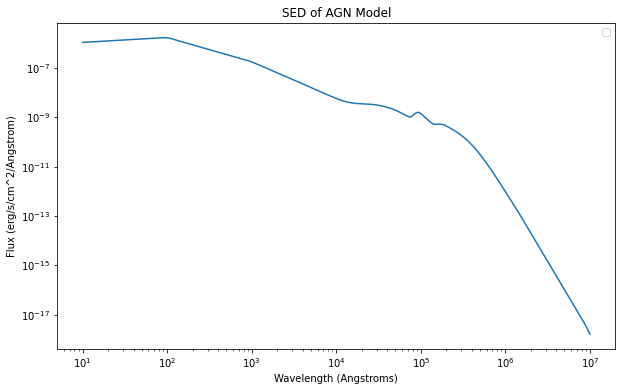

In [19]:
# Now we have an SED, plot this SED.
# This will be a plot of our AGN Model on a loglog plot, making sure Total Flux is plotted in the units 
# as defined below. It is best to combine SEDs when both the fluxes are in the same units
plt.figure(figsize=(10, 6))
plt.loglog(df['lambda (Angstroms)'], df['Total Flux (erg/s/cm^2/Angstrom)'], label='')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('SED of AGN Model')
plt.legend()
plt.show()


In [20]:
# Additionally we would like to read in some templates, to begin with, let us read in the SWIRE templates
# This are a small set of templates which can show spirals, ellipticals, starbursts, etc.

# SWIRE
swire_folderpath = os.path.join('datasets', 'Templates', 'SWIRE')



df_list = []
objname_list = []
swire_folderpath = os.path.join(swire_folderpath)
files_in_folder = os.listdir(swire_folderpath)

# make sure to only read .sed files
file_extension = '.sed'

# Filter files based on the specified file extension
files_in_folder = [file for file in files_in_folder if file.endswith(file_extension)]

for file in files_in_folder:
    # Find filepath and convert to df
    objname = file.split('_template_norm.sed')[0]
    filepath = os.path.join(swire_folderpath, file)
    data = np.loadtxt(filepath)
    df = pd.DataFrame(data)
    
    # Name each of the columns appropriately
    df.columns = ['lambda (Angstroms)', 'Total Flux (erg/s/cm^2/Angstrom)']
        
    # Append the dataframe to the list    
    df_list.append(df)
    objname_list.append(objname)


In [21]:
df =agn_df.copy()

Now we have a set of template galaxies, what we would like to do is to choose one of these templates and combine it with the model we have chosen. We can also see how each of these SEDs look, both seperately and together.

In [22]:
# First choose a galaxy, we would like to use the starburst galaxy, M82
n = 8
print(objname_list[n])
df_list[n]

m82 = df_list[n]


M82


In [23]:
m82

,lambda (Angstroms),Total Flux (erg/s/cm^2/Angstrom)
0,1005.0,4.388800e-01
1,1015.0,4.119000e-01
2,1025.0,2.457720e-01
3,1035.0,3.073080e-01
4,1045.0,5.052200e-01
...,...,...
1213,40640000.0,1.649570e-08
1214,46240000.0,1.320610e-08
1215,52610000.0,1.062980e-08
1216,59860000.0,8.584740e-09


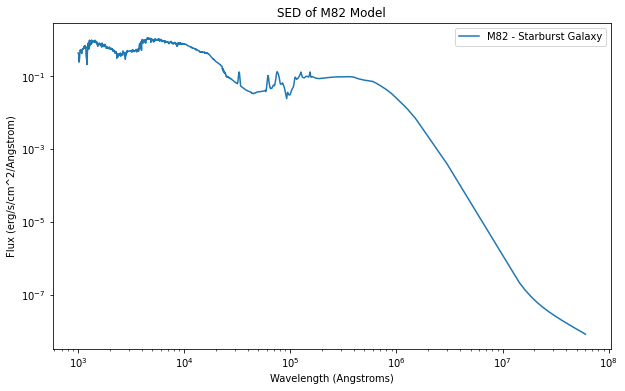

In [24]:
# Let's plot the output of M82, and see what it's SED looks like
plt.figure(figsize=(10, 6))
plt.loglog(m82['lambda (Angstroms)'], m82['Total Flux (erg/s/cm^2/Angstrom)'], label='M82 - Starburst Galaxy')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('SED of M82 Model')
plt.legend()
plt.show()


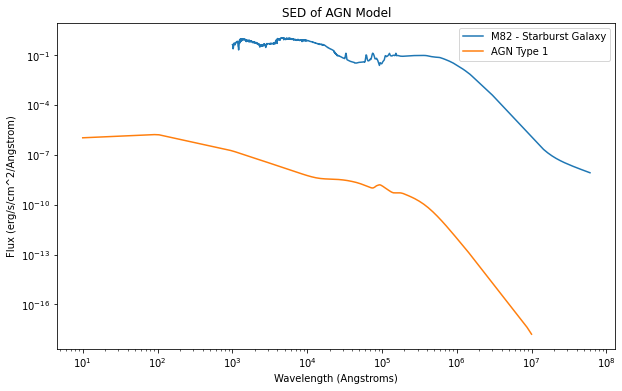

In [25]:
# Plotting these togeteher, we can see the difference in their scales
plt.figure(figsize=(10, 6))
plt.loglog(m82['lambda (Angstroms)'], m82['Total Flux (erg/s/cm^2/Angstrom)'], label='M82 - Starburst Galaxy')
plt.loglog(df['lambda (Angstroms)'], df['Total Flux (erg/s/cm^2/Angstrom)'], label='AGN Type 1')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('SED of AGN Model')
plt.legend()
plt.show()


We see that while similar, each of these SEDs may operate on slightly different scales, to account for this the prefered method in combining SEDs is to normalize the SEDs. To do this effectively we must calculate the integral of the flux for each of these SEDs, and subsequently create a scaling factor. This scaling factor must then be used to scale the AGN SED.

to combine SEDs, in particular for AGN (this may differ for galaxy + dusty templates) we combine by assuming the following 

$SED_{total} = SED_{galaxy} + \alpha \cdot SED_{AGN}$

where alpha is a value used to denote the percentage of AGN (or dusty template) contribution to your underlying galaxy SED.

Before any of this is done we need to make sure of a few things. We first must ensure that we have wavelength values that are shared amongst both SEDs such that when we combine the flux values for each SED, we are combining the fluxes at each wavelength. This may lead to some missing flux values at some wavelengths, so we can interpolate between these wavelengts subsequently replacing missing flux values at these wavelengths. In the case that we are dealing with a different wavelength range, as can be the case with some models, we can reduce the wavelength range of the SED and model to match, dropping values outside of this range.

In [26]:
# We begin by adjusting the wavelength range of the SED and AGN model.

# Given an SED
wavelengths_sed1 = m82['lambda (Angstroms)']
flux_sed1 = m82['Total Flux (erg/s/cm^2/Angstrom)']

# Given a model
wavelengths_sed2 = df['lambda (Angstroms)']
flux_sed2 = df['Total Flux (erg/s/cm^2/Angstrom)']

# Get a shared wavelength range across both SEDS
combined_wavelengths = np.union1d(wavelengths_sed1, wavelengths_sed2)

# Interpolate flux values for the combined wavelengths
combined_flux_sed1 = np.interp(combined_wavelengths, wavelengths_sed1, flux_sed1, left=np.nan, right=np.nan)
combined_flux_sed2 = np.interp(combined_wavelengths, wavelengths_sed2, flux_sed2, left=np.nan, right=np.nan) 

# We would like to see which sed has the min wavelength , and max wavelength,
# Cut the AGN and Galaxy model so they are within range of the original swire model
min_wavelength = np.max([np.min(wavelengths_sed1), np.min(wavelengths_sed2)])
max_wavelength = np.min([np.max(wavelengths_sed1), np.max(wavelengths_sed2)])

# Cut the AGN model
mask = (combined_wavelengths >= min_wavelength) & (combined_wavelengths <= max_wavelength)
combined_wavelengths = combined_wavelengths[mask]
combined_flux_sed1 = combined_flux_sed1[mask]
combined_flux_sed2 = combined_flux_sed2[mask]

# Create a new dataframe for each SED
m82 = pd.DataFrame({'lambda (Angstroms)': combined_wavelengths, 'Total Flux (erg/s/cm^2/Angstrom)': combined_flux_sed1}) 
df = pd.DataFrame({'lambda (Angstroms)': combined_wavelengths, 'Total Flux (erg/s/cm^2/Angstrom)': combined_flux_sed2}) 


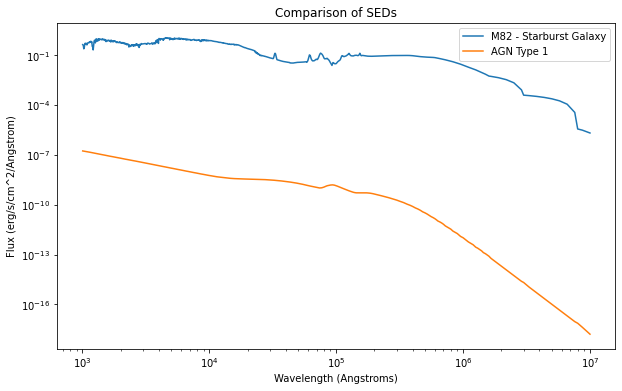

In [27]:
# We can now plot the SEDs together, on the same plot to see the adustment -noting they should not have changed much
plt.figure(figsize=(10, 6))
plt.loglog(m82['lambda (Angstroms)'], m82['Total Flux (erg/s/cm^2/Angstrom)'], label='M82 - Starburst Galaxy')
plt.loglog(df['lambda (Angstroms)'], df['Total Flux (erg/s/cm^2/Angstrom)'], label='AGN Type 1')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Comparison of SEDs')
plt.legend()
plt.show()

In [28]:
# Our next step is to normalize these SEDs by using the integral of the flux, subsequently calculating a scaling factor to normalize our model with.
# This is done by integrating the flux over the wavelength range of the SED, and model, 

# Create a function to compute the flux integral
def integral_flux(sed):
    return np.trapz(sed['Total Flux (erg/s/cm^2/Angstrom)'], sed['lambda (Angstroms)'])



In [29]:
# Calculating the integrated flux for each SED
integrated_model_flux = integral_flux(df)
integrated_galaxy_flux = integral_flux(m82)
scaling_factor = integrated_galaxy_flux/integrated_model_flux

# Using this scaling factor, we can now scale the model to the galaxy model
df['Total Flux (erg/s/cm^2/Angstrom)'] = df['Total Flux (erg/s/cm^2/Angstrom)'] * scaling_factor

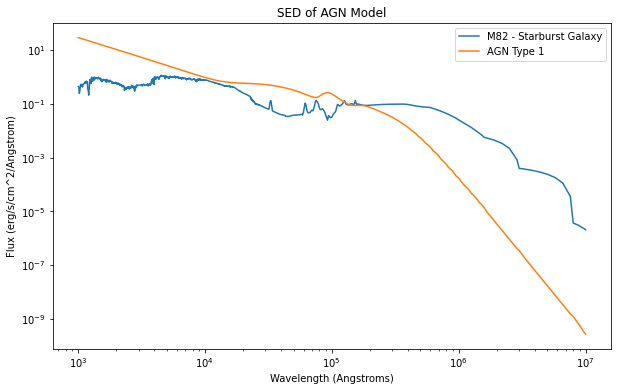

In [30]:
# We can now again plot both SEDs to see the effect of the scaling factor, seeing that they are now on the same scale, and compareable,
# and thus can be turned into a composite
plt.figure(figsize=(10, 6))
plt.loglog(m82['lambda (Angstroms)'], m82['Total Flux (erg/s/cm^2/Angstrom)'], label='M82 - Starburst Galaxy')
plt.loglog(df['lambda (Angstroms)'], df['Total Flux (erg/s/cm^2/Angstrom)'], label='AGN Type 1')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('SED of AGN Model')
plt.legend()
plt.show()

From above we see that while there isn't an enormous difference, there is a change in the SED profile of both galaxies. This is good and will allow us to now combine both SEDs, and create a new composite.

In [31]:
# Using some simple math we can combine the SEDs to create a composite, which we can plot
# Sum the flux values at each wavelength. We will show this for an increasing model contribution from 0 to 100%
# in steps of 0.2
alpha = np.arange(0, 1.2, 0.2)
alpha

# creating a set of composite SEDs
composite_seds = []
for a in alpha:
    combined_flux = a * df['Total Flux (erg/s/cm^2/Angstrom)'] + m82['Total Flux (erg/s/cm^2/Angstrom)']
    
    # use the wavelength of the galaxy SED or AGN sed
    combined_wavelengths = df['lambda (Angstroms)']

    # Create a composite SED DataFrame
    composite_sed_df = pd.DataFrame({'lambda (Angstroms)': combined_wavelengths, 'Total Flux (erg/s/cm^2/Angstrom)': combined_flux})
    
    # add to composite sed list
    composite_seds.append(composite_sed_df)


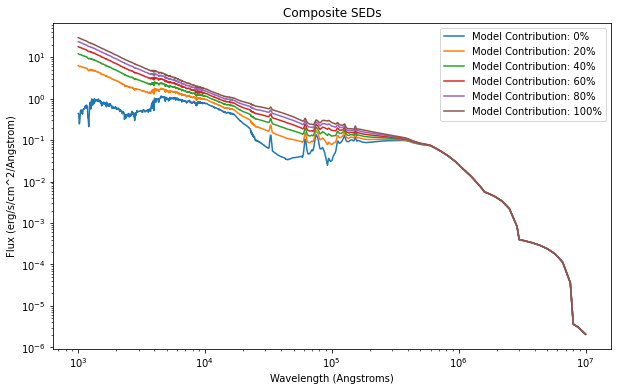

In [32]:
# We can now plot these SEDs and see what an increase of model contribution does to the overal SED
plt.figure(figsize=(10, 6))
for i, composite_sed in enumerate(composite_seds):
    plt.loglog(composite_sed['lambda (Angstroms)'], composite_sed['Total Flux (erg/s/cm^2/Angstrom)'], label=f'Model Contribution: {alpha[i]*100:.0f}%')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/s/cm^2/Angstrom)')
plt.title('Composite SEDs')
plt.legend()
plt.show()

